,step,success_probability
0,0,0.250000
1,1,0.250000
2,2,0.694444
3,3,0.003086
4,4,0.057956
5,5,0.868808
6,6,0.112487
7,7,0.033035
8,8,0.577169
9,9,0.278831


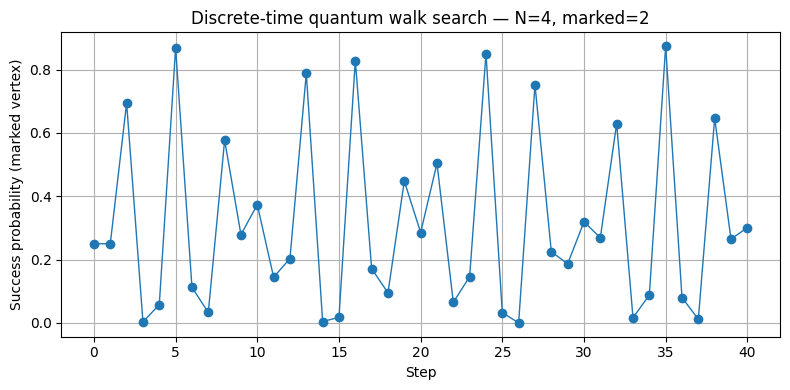

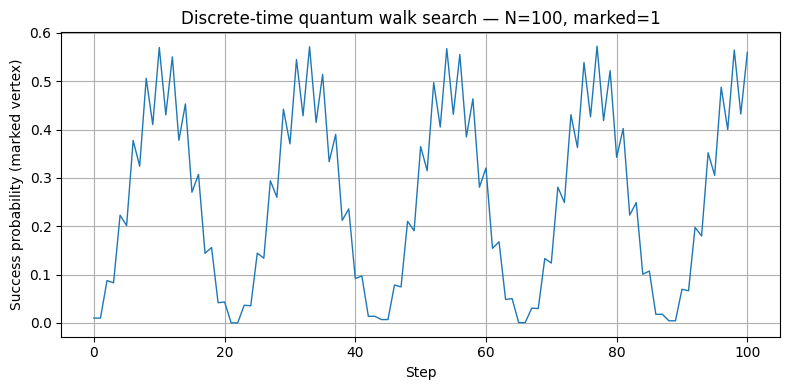

N=4: max success probability = 0.873826 at step 35
N=100: max success probability = 0.572414 at step 77


(array([2.50000000e-01, 2.50000000e-01, 6.94444444e-01, 3.08641975e-03,
        5.79561043e-02, 8.68808109e-01, 1.12487087e-01, 3.30351817e-02,
        5.77169170e-01, 2.78831000e-01, 3.73332610e-01, 1.44424198e-01,
        2.03447863e-01, 7.88610478e-01, 4.39983993e-03, 1.76701309e-02,
        8.28530818e-01, 1.71440051e-01, 9.51728148e-02, 4.48076695e-01,
        2.85527782e-01, 5.03738464e-01, 6.48657371e-02, 1.46430249e-01,
        8.50444010e-01, 3.24954322e-02, 2.30291349e-04, 7.51975771e-01,
        2.25034930e-01, 1.86629119e-01, 3.19267077e-01, 2.69072760e-01,
        6.29259971e-01, 1.63098769e-02, 8.81333326e-02, 8.73826088e-01,
        8.00001352e-02, 1.18818608e-02, 6.46691030e-01, 2.64777457e-01,
        3.00943006e-01]),
 array([1.00000000e-02, 1.00000000e-02, 8.75920824e-02, 8.29211990e-02,
        2.22900736e-01, 2.01393819e-01, 3.77399583e-01, 3.24327314e-01,
        5.05721638e-01, 4.10161417e-01, 5.69689043e-01, 4.30189952e-01,
        5.50162487e-01, 3.77740382e-01

In [ ]:
# Simulation of the discrete-time quantum walk search (Grover-like coin + shift + oracle)
# - Uses state vector of length N*(N-1) representing amplitudes alpha_{i->j} for i != j
# - Coin: Grover coin per vertex (reflection about average of outgoing amplitudes)
# - Oracle: flips sign of amplitudes outgoing from the marked vertex
# - Shift: swaps amplitude of i->j with j->i
#
# Produces:
# - Table of success probabilities for first 10 steps (N=4)
# - Plot of success probability vs steps for N=4 (40 steps)
# - Plot of success probability vs steps for N=100 (100 steps)
#
# Notes:
# - Vertices are 0-indexed in the code. To match the writeup's "vertex 2 is marked", use marked=1.
# - This implementation works efficiently without assembling large dense matrices by operating per-vertex.
# - Adjust N and steps below as desired.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # Import the standard display function

def build_index_map(N):
    """Return lists mapping each directed edge index to (i,j) and vice versa.
    Only edges with i != j are included. Indices go from 0..M-1 where M = N*(N-1).
    """
    idx_to_pair = []
    pair_to_idx = {}
    idx = 0
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            idx_to_pair.append((i, j))
            pair_to_idx[(i, j)] = idx
            idx += 1
    return idx_to_pair, pair_to_idx

def uniform_state(N):
    """Return uniform state vector (length N*(N-1))."""
    M = N * (N - 1)
    amp = 1.0 / np.sqrt(M)
    return np.full(M, amp, dtype=np.complex128)

def oracle_flip(state, idx_to_pair, marked):
    """Flip the sign of all amplitudes outgoing from 'marked' vertex (i == marked)."""
    # state is modified in place
    for idx, (i, j) in enumerate(idx_to_pair):
        if i == marked:
            state[idx] = -state[idx]

def coin_grover_inplace(state, idx_to_pair, N):
    """Apply Grover coin in-place: reflect outgoing amplitudes at each vertex about their average."""
    # We'll group indices by source vertex
    # For each vertex i, get indices of outgoing edges and perform: a -> 2*mean - a
    start = 0
    for i in range(N):
        # outgoing indices for vertex i are at positions where idx_to_pair[k][0] == i
        # They are (N-1) entries; compute mean and reflect
        # We'll gather them quickly by slicing through idx_to_pair sequentially
        outgoing_indices = [k for k, (src, dst) in enumerate(idx_to_pair) if src == i]
        if not outgoing_indices:
            continue
        amps = state[outgoing_indices]
        mean = np.mean(amps)
        state[outgoing_indices] = 2*mean - amps

def shift_swap_inplace(state, idx_to_pair, pair_to_idx):
    """Apply shift operator by swapping amplitude for (i->j) with (j->i)."""
    # We'll build the permutation mapping and then apply swaps (ensure each pair swapped once)
    visited = set()
    for idx, (i, j) in enumerate(idx_to_pair):
        if (i, j) in visited:
            continue
        # counterpart is (j, i)
        other_idx = pair_to_idx[(j, i)]
        if other_idx == idx:
            # shouldn't happen since i != j
            continue
        # swap
        a = state[idx].copy()
        b = state[other_idx].copy()
        state[idx] = b
        state[other_idx] = a
        visited.add((i, j))
        visited.add((j, i))

def success_probability(state, idx_to_pair, marked):
    """Probability of finding the walker at vertex 'marked' (sum of |alpha_{marked->j}|^2)."""
    prob = 0.0
    for idx, (i, j) in enumerate(idx_to_pair):
        if i == marked:
            prob += np.abs(state[idx])**2
    return prob

def run_quantum_walk(N, marked, steps, return_all_probs=True):
    idx_to_pair, pair_to_idx = build_index_map(N)
    state = uniform_state(N)
    probs = [success_probability(state, idx_to_pair, marked)]
    # Steps: each step = oracle -> coin -> shift
    for t in range(1, steps+1):
        oracle_flip(state, idx_to_pair, marked)
        coin_grover_inplace(state, idx_to_pair, N)
        shift_swap_inplace(state, idx_to_pair, pair_to_idx)
        probs.append(success_probability(state, idx_to_pair, marked))
    if return_all_probs:
        return np.array(probs), state, idx_to_pair
    else:
        return probs[-1], state, idx_to_pair

# ------------------------- Run examples -------------------------

# Example 1: N=4 with marked vertex 2 in the paper -> marked index = 1 (0-based)
N1 = 4
marked1 = 1  # corresponds to 'vertex 2' in 1-based notation
steps1 = 40
probs1, final_state1, idx_to_pair1 = run_quantum_walk(N1, marked1, steps1)

# Prepare a small table for first 10 steps for N=4
table_rows = []
for t in range(0, 11):
    table_rows.append({"step": t, "success_probability": probs1[t]})
df_steps_n4 = pd.DataFrame(table_rows)

# Show the table to the user (pandas DataFrame will be displayed)
display(df_steps_n4)

# Plot success probability vs steps for N=4
plt.figure(figsize=(8,4))
plt.plot(range(0, steps1+1), probs1, marker='o', linewidth=1)
plt.xlabel("Step")
plt.ylabel("Success probability (marked vertex)")
plt.title(f"Discrete-time quantum walk search — N={N1}, marked={marked1+1}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Example 2: Larger N to show suppression of step-to-step oscillations (N=100)
N2 = 100
marked2 = 0  # choose vertex 1 as marked
steps2 = 100
probs2, final_state2, idx_to_pair2 = run_quantum_walk(N2, marked2, steps2)

# Plot success probability vs steps for N=100
plt.figure(figsize=(8,4))
plt.plot(range(0, steps2+1), probs2, linewidth=1)
plt.xlabel("Step")
plt.ylabel("Success probability (marked vertex)")
plt.title(f"Discrete-time quantum walk search — N={N2}, marked={marked2+1}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also print the max success probability and step at which it occurs for both cases
def summary_stats(probs):
    max_p = np.max(probs)
    argmax = int(np.argmax(probs))
    return max_p, argmax

summary_n4 = summary_stats(probs1)
summary_n100 = summary_stats(probs2)

print(f"N={N1}: max success probability = {summary_n4[0]:.6f} at step {summary_n4[1]}")
print(f"N={N2}: max success probability = {summary_n100[0]:.6f} at step {summary_n100[1]}")

# Return variables to the notebook environment (useful for further interactive exploration)
probs1, probs2, df_steps_n4[:11]

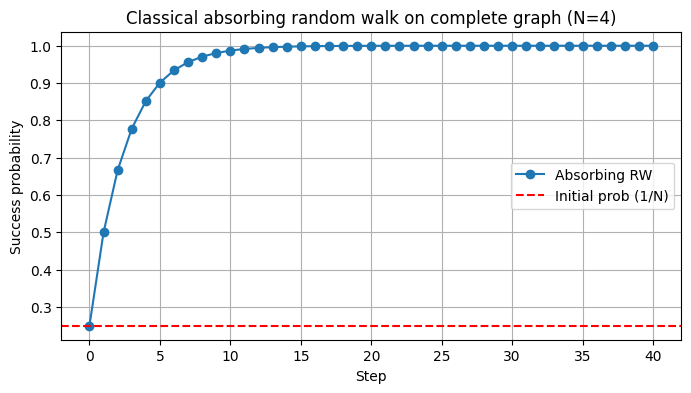

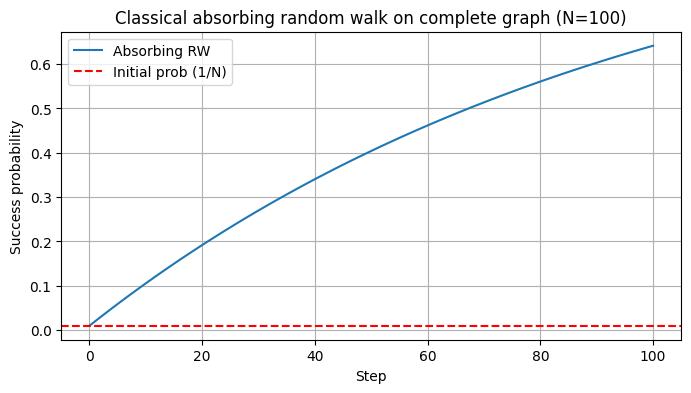

(array([0.25      , 0.5       , 0.66666667, 0.77777778, 0.85185185,
        0.90123457, 0.93415638, 0.95610425, 0.97073617, 0.98049078,
        0.98699385]),
 array([0.01      , 0.02      , 0.02989899, 0.03969799, 0.04939801,
        0.05900005, 0.0685051 , 0.07791414, 0.08722814, 0.09644806,
        0.10557484]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def absorbing_random_walk_complete_graph(N, marked, steps):
    """Simulate classical random walk with absorbing marked vertex."""
    # Build transition matrix P according to Eq. (2)
    P = np.zeros((N, N))
    for j in range(N):
        if j == marked:
            P[j, j] = 1  # absorbing state
        else:
            for i in range(N):
                if i != j:
                    P[i, j] = 1/(N-1)
    # Initial state: uniform distribution
    p = np.full(N, 1/N)
    probs = [p[marked]]
    for _ in range(steps):
        p = P @ p
        probs.append(p[marked])
    return np.array(probs)

# Parameters
N1 = 4
marked1 = 1  # vertex 2 in 1-based
steps1 = 40
N2 = 100
marked2 = 0
steps2 = 100

# Run absorbing random walk simulations
probs_absorb_n4 = absorbing_random_walk_complete_graph(N1, marked1, steps1)
probs_absorb_n100 = absorbing_random_walk_complete_graph(N2, marked2, steps2)

# Plot for N=4
plt.figure(figsize=(8,4))
plt.plot(range(0, steps1+1), probs_absorb_n4, marker='o', label="Absorbing RW")
plt.axhline(1/N1, color='red', linestyle='--', label="Initial prob (1/N)")
plt.xlabel("Step")
plt.ylabel("Success probability")
plt.title("Classical absorbing random walk on complete graph (N=4)")
plt.legend()
plt.grid(True)
plt.show()

# Plot for N=100
plt.figure(figsize=(8,4))
plt.plot(range(0, steps2+1), probs_absorb_n100, label="Absorbing RW")
plt.axhline(1/N2, color='red', linestyle='--', label="Initial prob (1/N)")
plt.xlabel("Step")
plt.ylabel("Success probability")
plt.title("Classical absorbing random walk on complete graph (N=100)")
plt.legend()
plt.grid(True)
plt.show()

probs_absorb_n4[:11], probs_absorb_n100[:11]
